In [ ]:
import os
import matplotlib.pyplot as plt
import polars as pl
from utils import *
from hftbacktest import BacktestAsset, ROIVectorMarketDepthBacktest, Recorder, HashMapMarketDepthBacktest
from hftbacktest.stats import LinearAssetRecord
from hft_strat import *

In [ ]:
pair = "TRUMPUSDT"
date = "20250501"
data_name = f'{pair}_{date}'
data = os.path.join(DATA_DIR, f"{data_name}.npz")

asset = (
    BacktestAsset()
        .data(data)
        .initial_snapshot(data)
        .linear_asset(1.0)
        .constant_latency(100_000_000, 100_000_000)
        .risk_adverse_queue_model()
        .power_prob_queue_model(2.0)
        .no_partial_fill_exchange()
        .trading_value_fee_model(0.0002, 0.0005)
        .tick_size(0.01)
        .lot_size(0.001)
        .roi_lb(0.0)
        .roi_ub(3000.0)
        .last_trades_capacity(10000)
)

hbt = HashMapMarketDepthBacktest([asset])

recorder = Recorder(
    hbt.num_assets,
    5_000_000
)

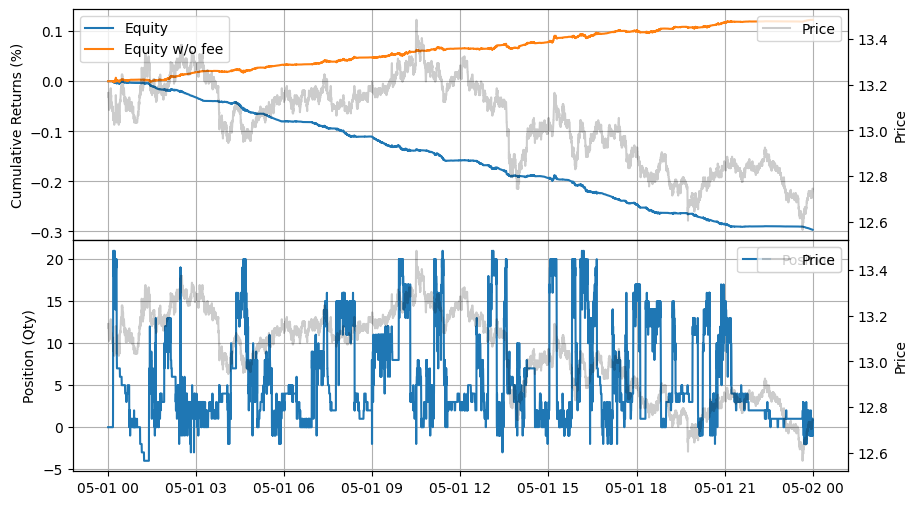

In [ ]:
out =  market_maker_glft(hbt, recorder.recorder, 1, 0.1, 0.00005)
hbt.close()

stats = LinearAssetRecord(recorder.get(0)).stats(book_size=30_000)
stats.summary()

stats.plot()
plt.show()

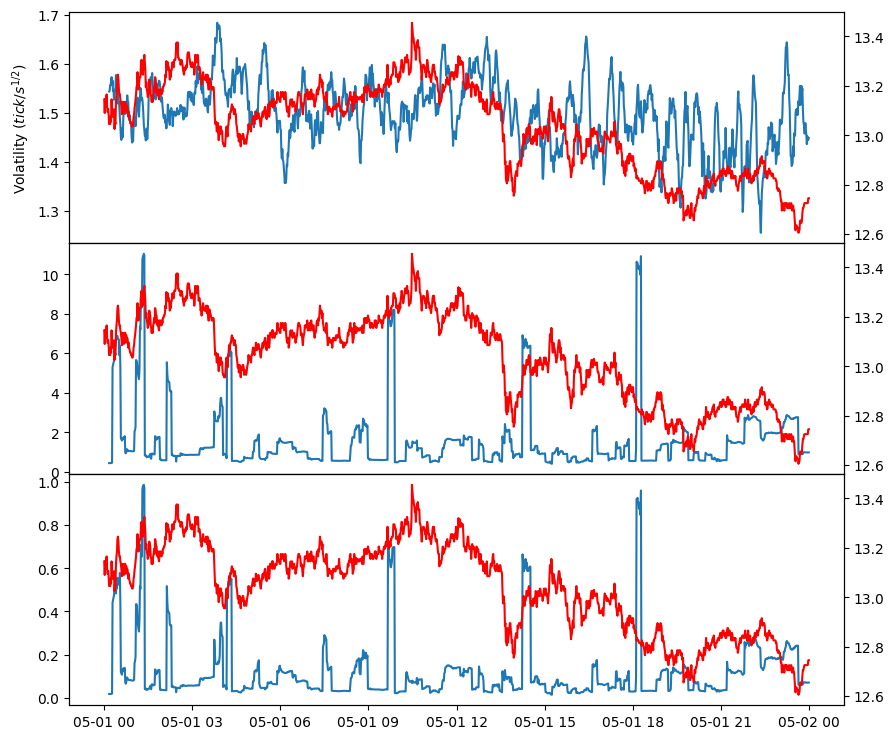

In [ ]:
records = recorder.get(0)
df = pl.DataFrame(out).with_columns(
    pl.Series('timestamp', records['timestamp']),
    pl.Series('price', records['price'])
).with_columns(
    pl.from_epoch('timestamp', time_unit='ns')
)

df = df.group_by_dynamic(
    'timestamp', every='1m'
).agg(
    pl.col('price').last(),
    pl.col('half_spread_tick').last(),
    pl.col('skew').last(),
    pl.col('volatility').last(),
    pl.col('A').last(),
    pl.col('k').last(),
)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(10, 9)

ax1.plot(df['timestamp'], df['volatility'])
ax1.twinx().plot(df['timestamp'], df['price'], 'r')
ax1.set_ylabel('Volatility ($ tick/s^{1/2} $)')

ax2.plot(df['timestamp'], df['half_spread_tick'])
ax2.twinx().plot(df['timestamp'], df['price'], 'r')

ax3.plot(df['timestamp'], df['skew'])
ax3.twinx().plot(df['timestamp'], df['price'], 'r')

plt.show()